In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm.notebook import tqdm

In [2]:
def trapezoid_impulse(t, tau, T1, T2):
    # T2 >= T1
    truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
    moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                                   np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
    h1, h2 = truncated_ramp(t, T1), moving_average(t, T2)
    h1_t_T2, h2_t_T1 = np.roll(truncated_ramp(t, T1), T2), np.roll(moving_average(t, T2), T1)
    h = h1 + tau*h2 + (T1-tau)*h2_t_T1 - h1_t_T2
    return h

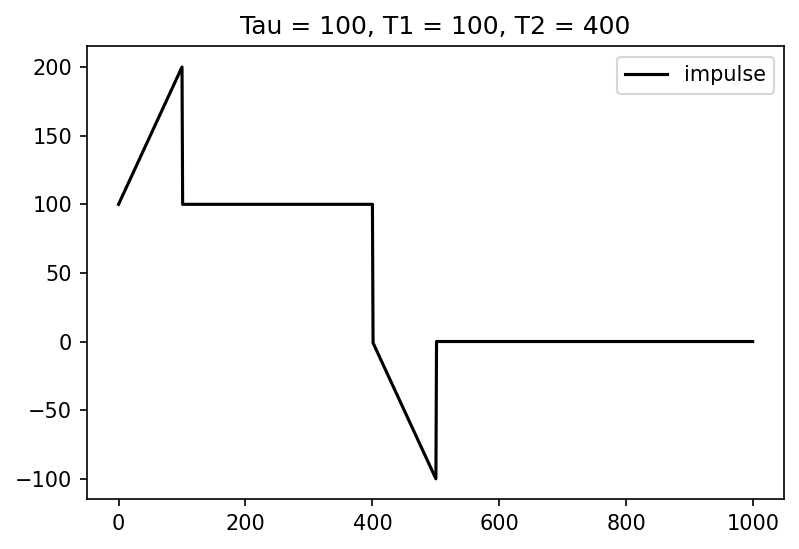

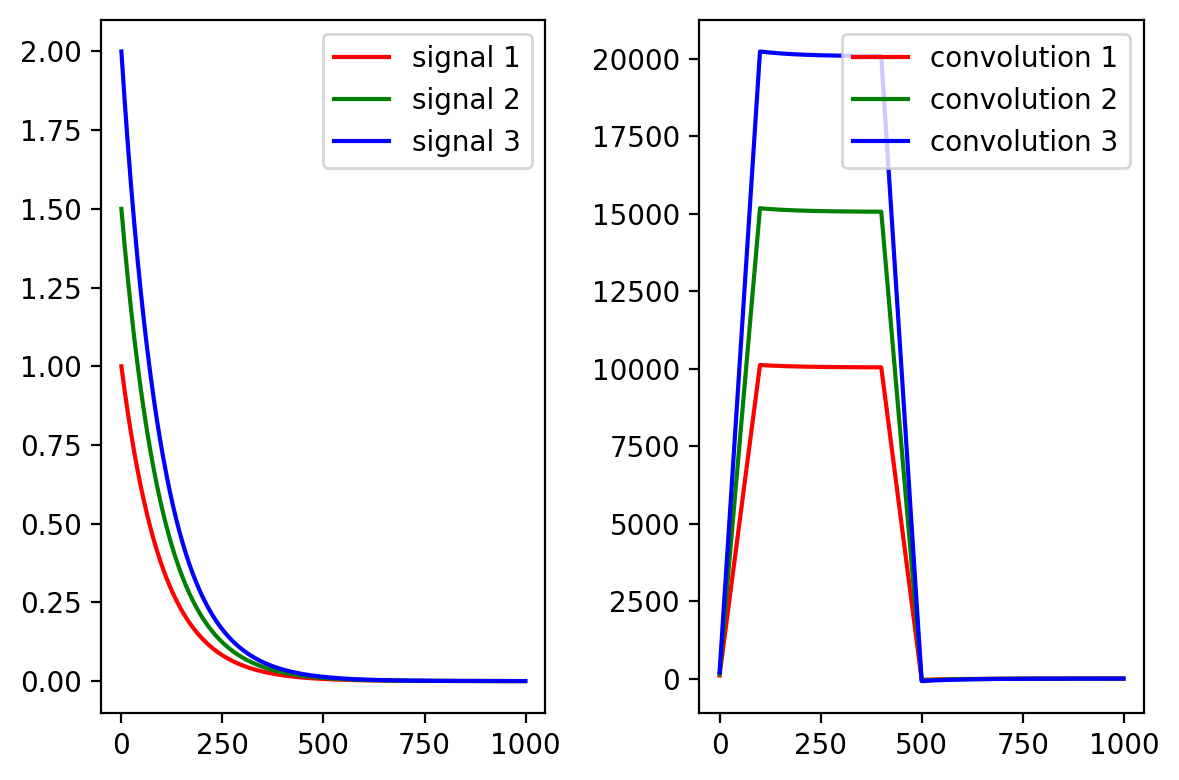

In [3]:
ln = 1000
t = np.linspace(0, 1000, ln)

test_exp = np.exp(-t/100)
test_exp2 = 1.5*np.exp(-t/100)
test_exp3 = 2*np.exp(-t/100)

tau, T1, T2 = 100, 100, 400
test = trapezoid_impulse(t, tau, T1, T2)

fig = plt.figure(dpi=150)
plt.plot(test, color='black', label='impulse')
plt.title('Tau = {}, T1 = {}, T2 = {}'.format(tau, T1, T2))
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.plot(test_exp, c='red', label='signal 1')
ax1.plot(test_exp2, c='green', label='signal 2')
ax1.plot(test_exp3, c='blue', label='signal 3')
ax1.legend()

ax2.plot(np.convolve(test_exp, test)[:ln], c='red', label='convolution 1')
ax2.plot(np.convolve(test_exp2, test)[:ln], c='green', label='convolution 2')
ax2.plot(np.convolve(test_exp3, test)[:ln], c='blue', label='convolution 3')
ax2.legend()
plt.tight_layout()
plt.show()

In [110]:
f = h5py.File('Data/Test-923/Co60-1min.h5', 'r')

In [111]:
test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

test_event = np.array(f['event_data'])
iss = []
for i in range(len(test_event)):
    if test_event[i][5] == 1:
        iss.append(i)

In [112]:
sat_i = []
for i in range(len(test_np)):
    if test_np[i][1400] == 16383:
        sat_i.append(i)

  0%|          | 0/200 [00:00<?, ?it/s]

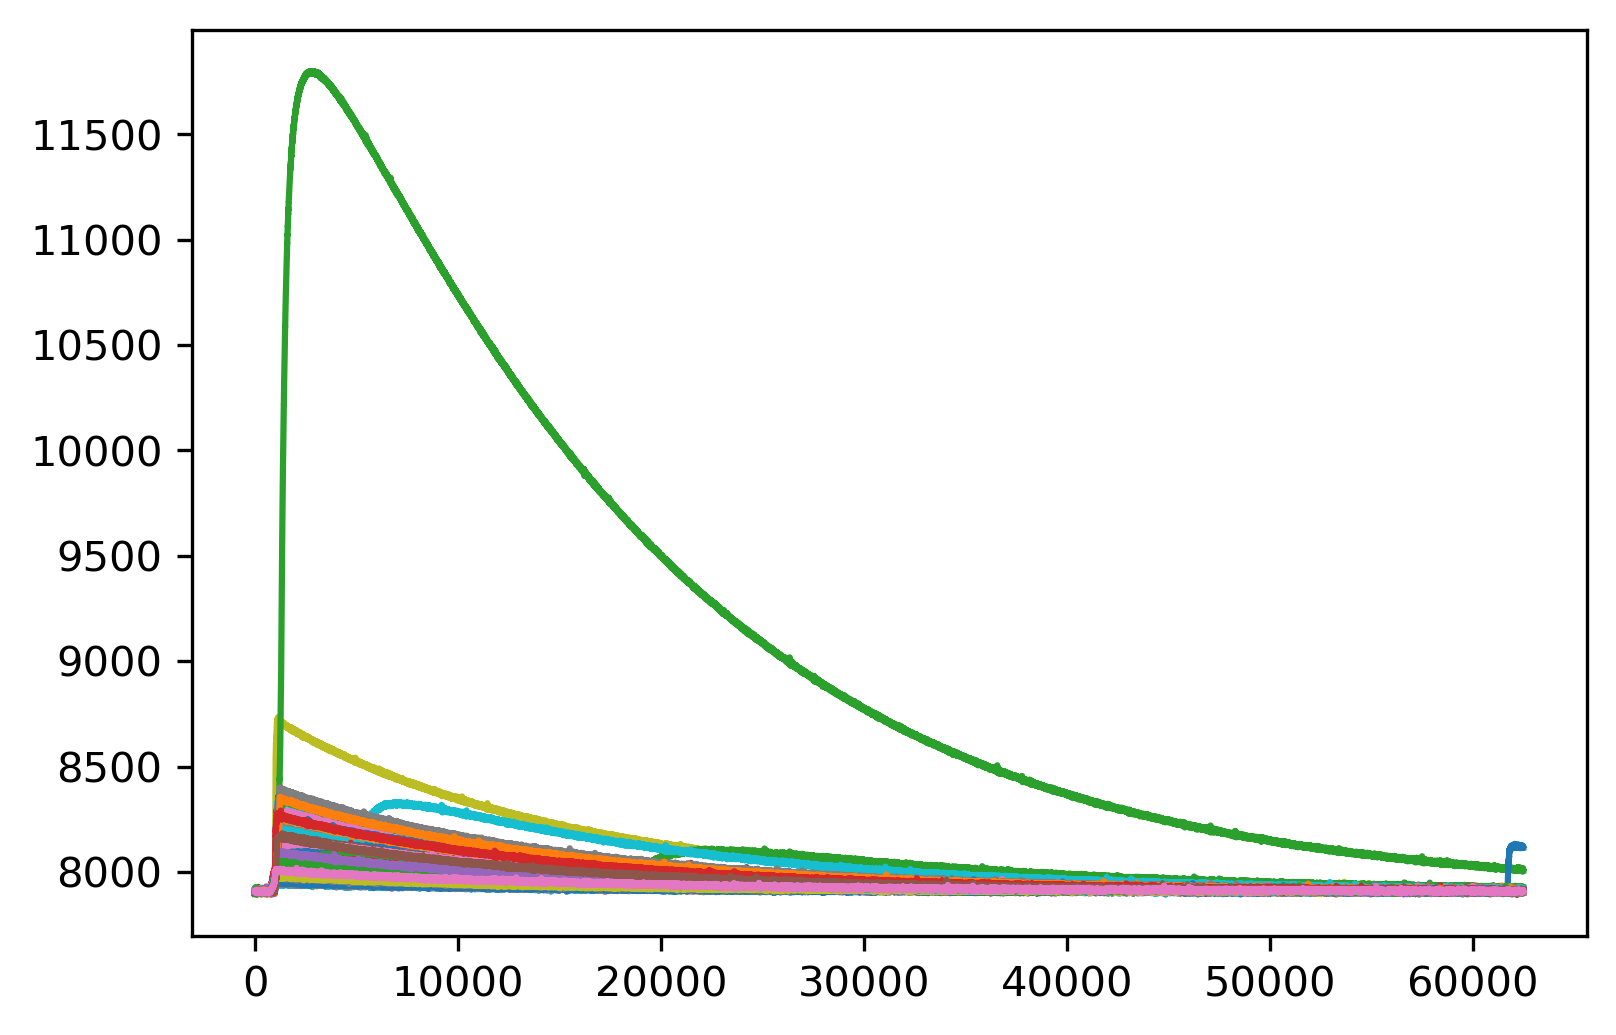

In [113]:
plt.figure(dpi=300)
for i in tqdm(range(200)):
    if i not in sat_i:
        plt.plot(test_np[i])
#plt.ylim(7800,8300)
plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

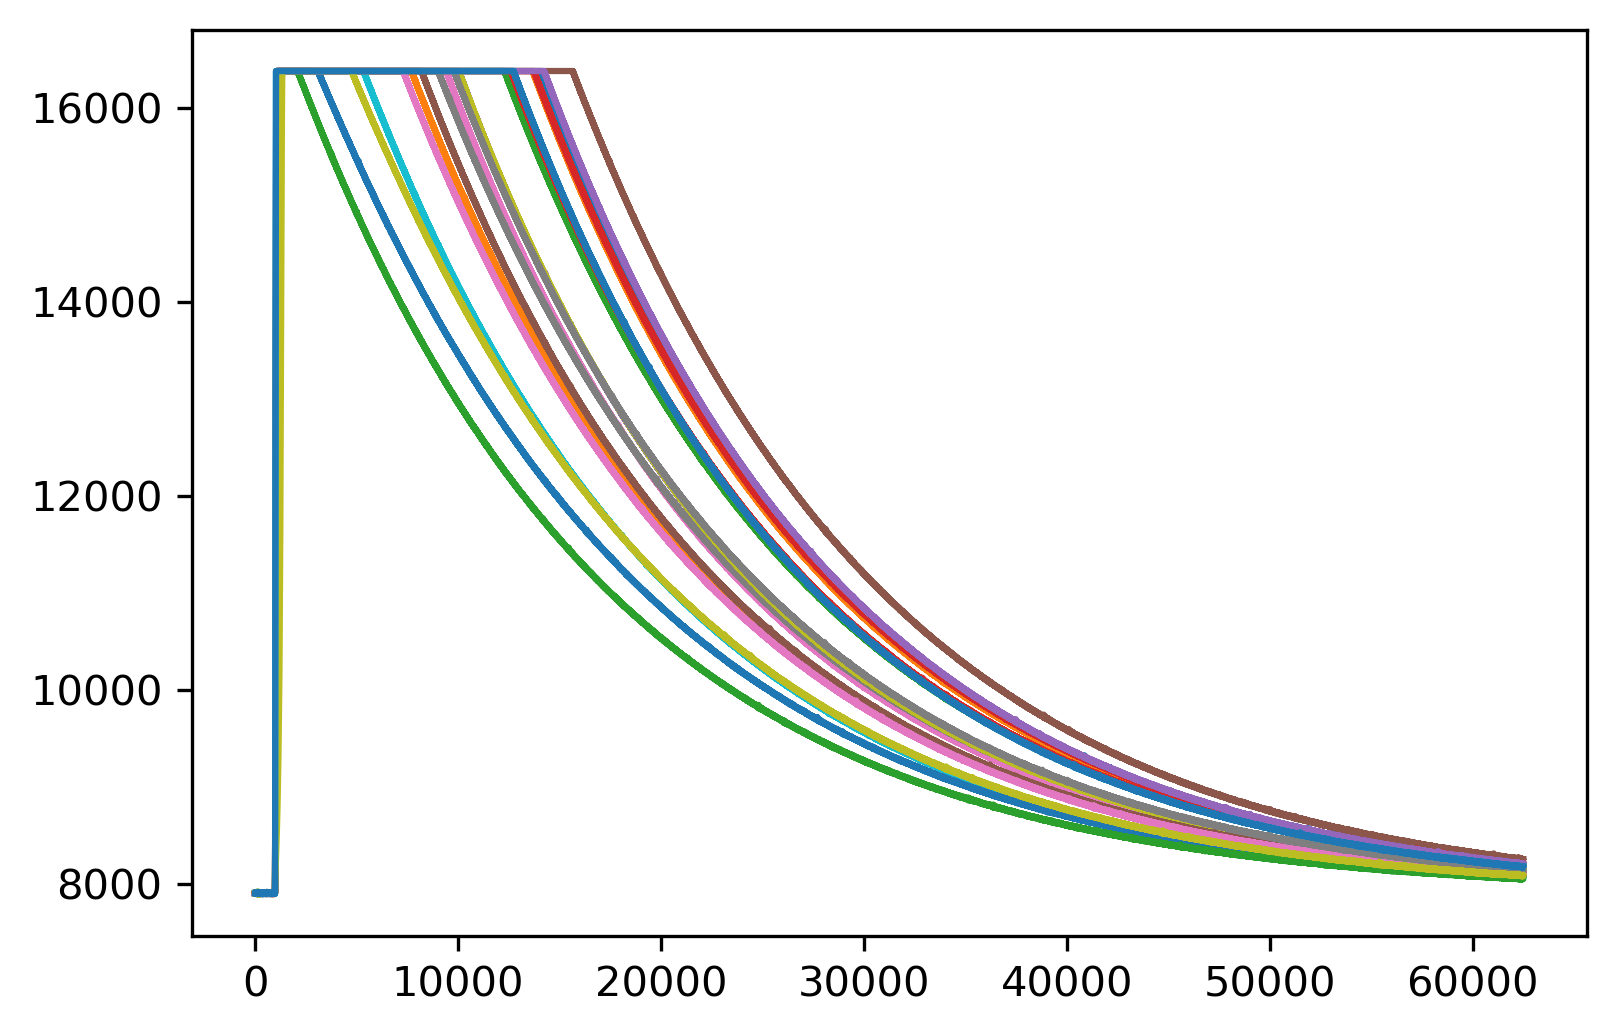

In [116]:
plt.figure(dpi=300)
for i in tqdm(sat_i):
    plt.plot(test_np[i])
#plt.ylim(7800,8300)
plt.show()

In [100]:
len(test_np)

359

  0%|          | 0/2868 [00:00<?, ?it/s]

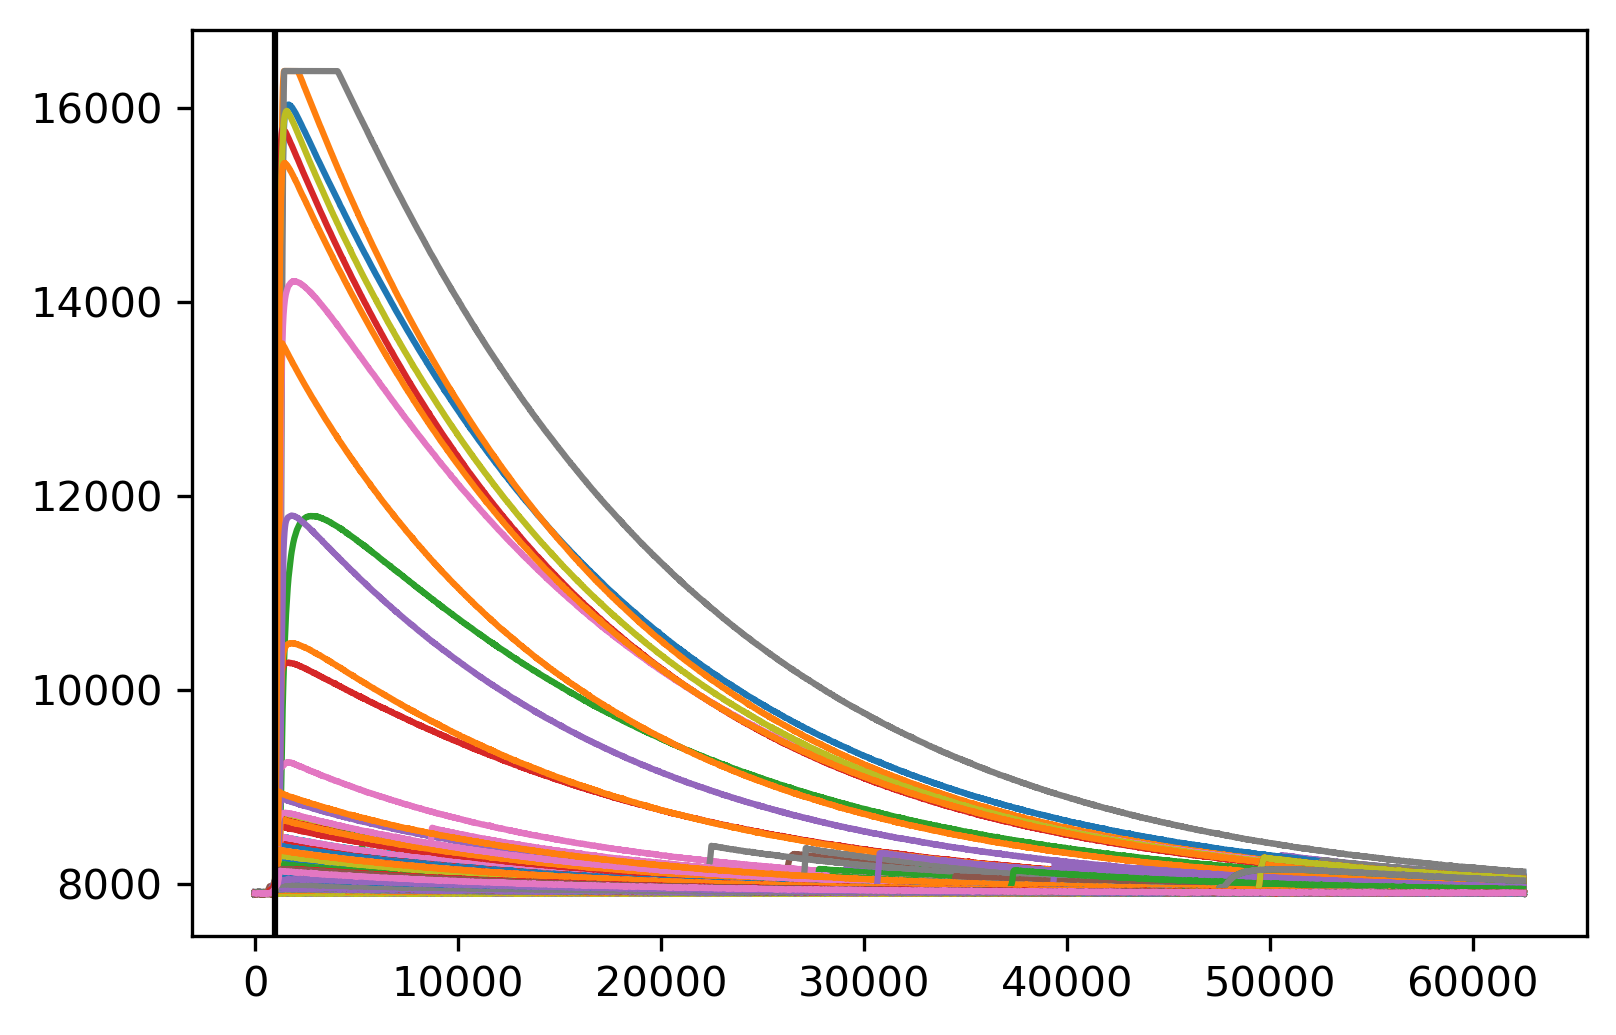

In [115]:
plt.figure(dpi=300)
for i in tqdm(range(len(test_np))):
    if i not in sat_i:
        plt.plot(savgol_filter(test_np[i], 21, 0))
#plt.xlim((700, 1200))
plt.axvline(1000, c='k')
#plt.ylim(7850, 8700)
plt.show()

  0%|          | 0/3162 [00:00<?, ?it/s]

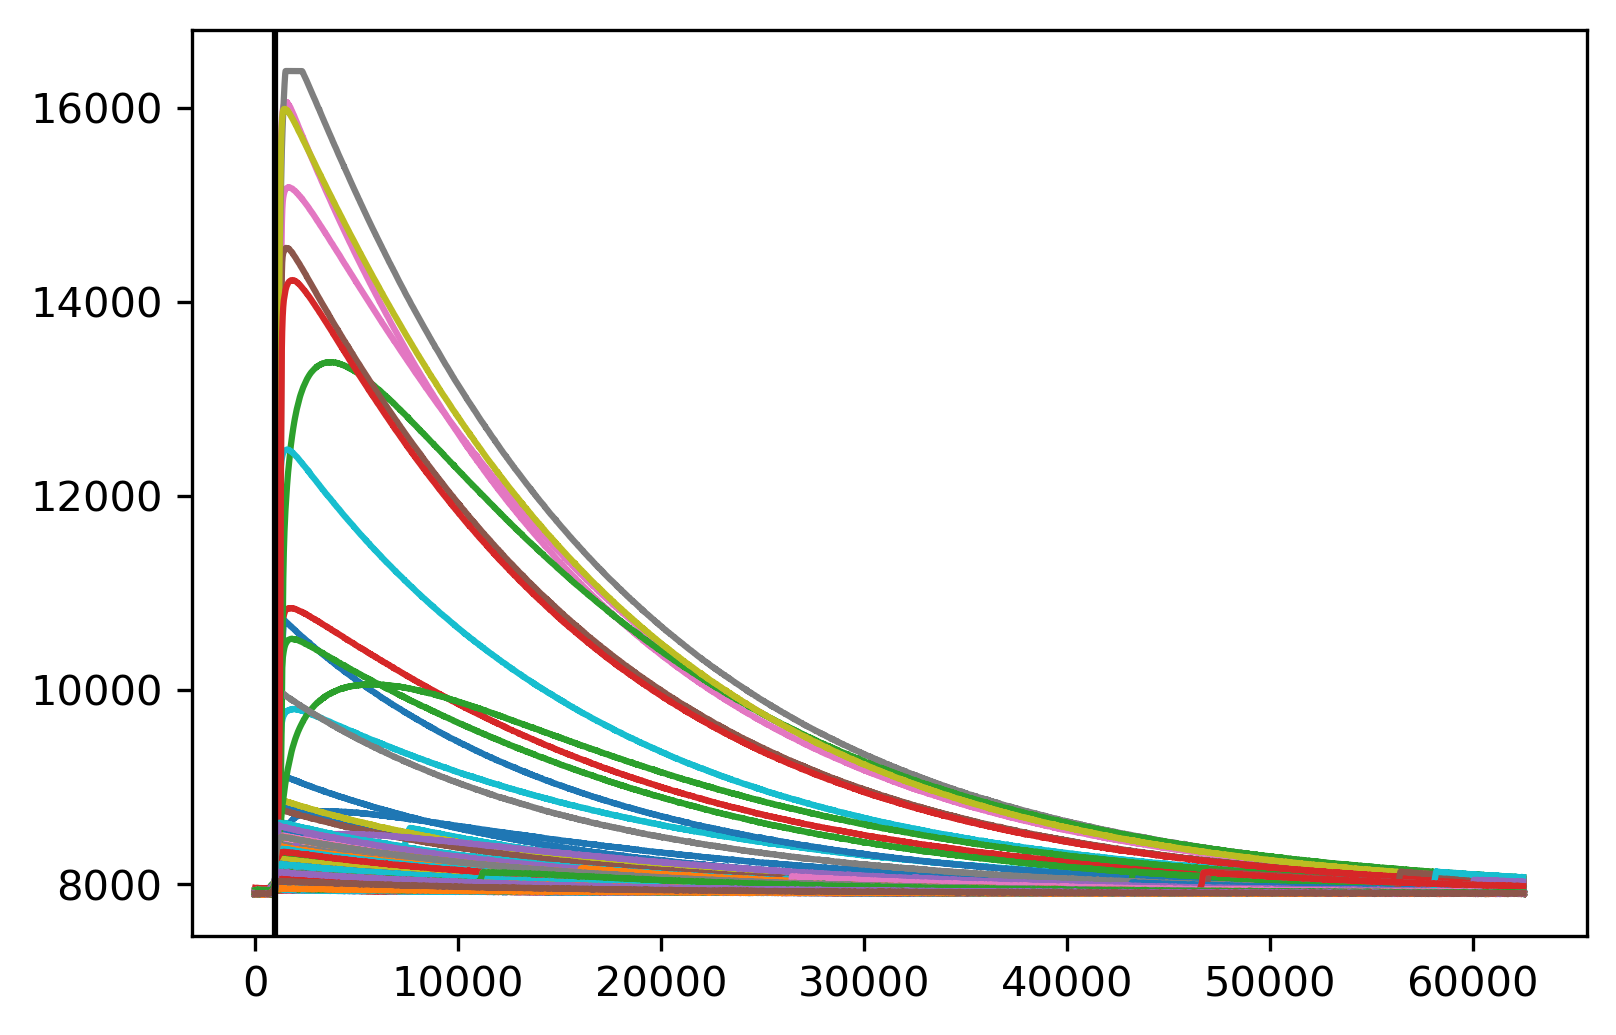

In [108]:
plt.figure(dpi=300)
for i in tqdm(range(len(test_np))):
    if i not in sat_i:
        plt.plot(savgol_filter(test_np[i], 21, 0))
#plt.xlim((700, 1200))
plt.axvline(1000, c='k')
#plt.ylim(7850, 8700)
plt.show()

  0%|          | 0/359 [00:00<?, ?it/s]

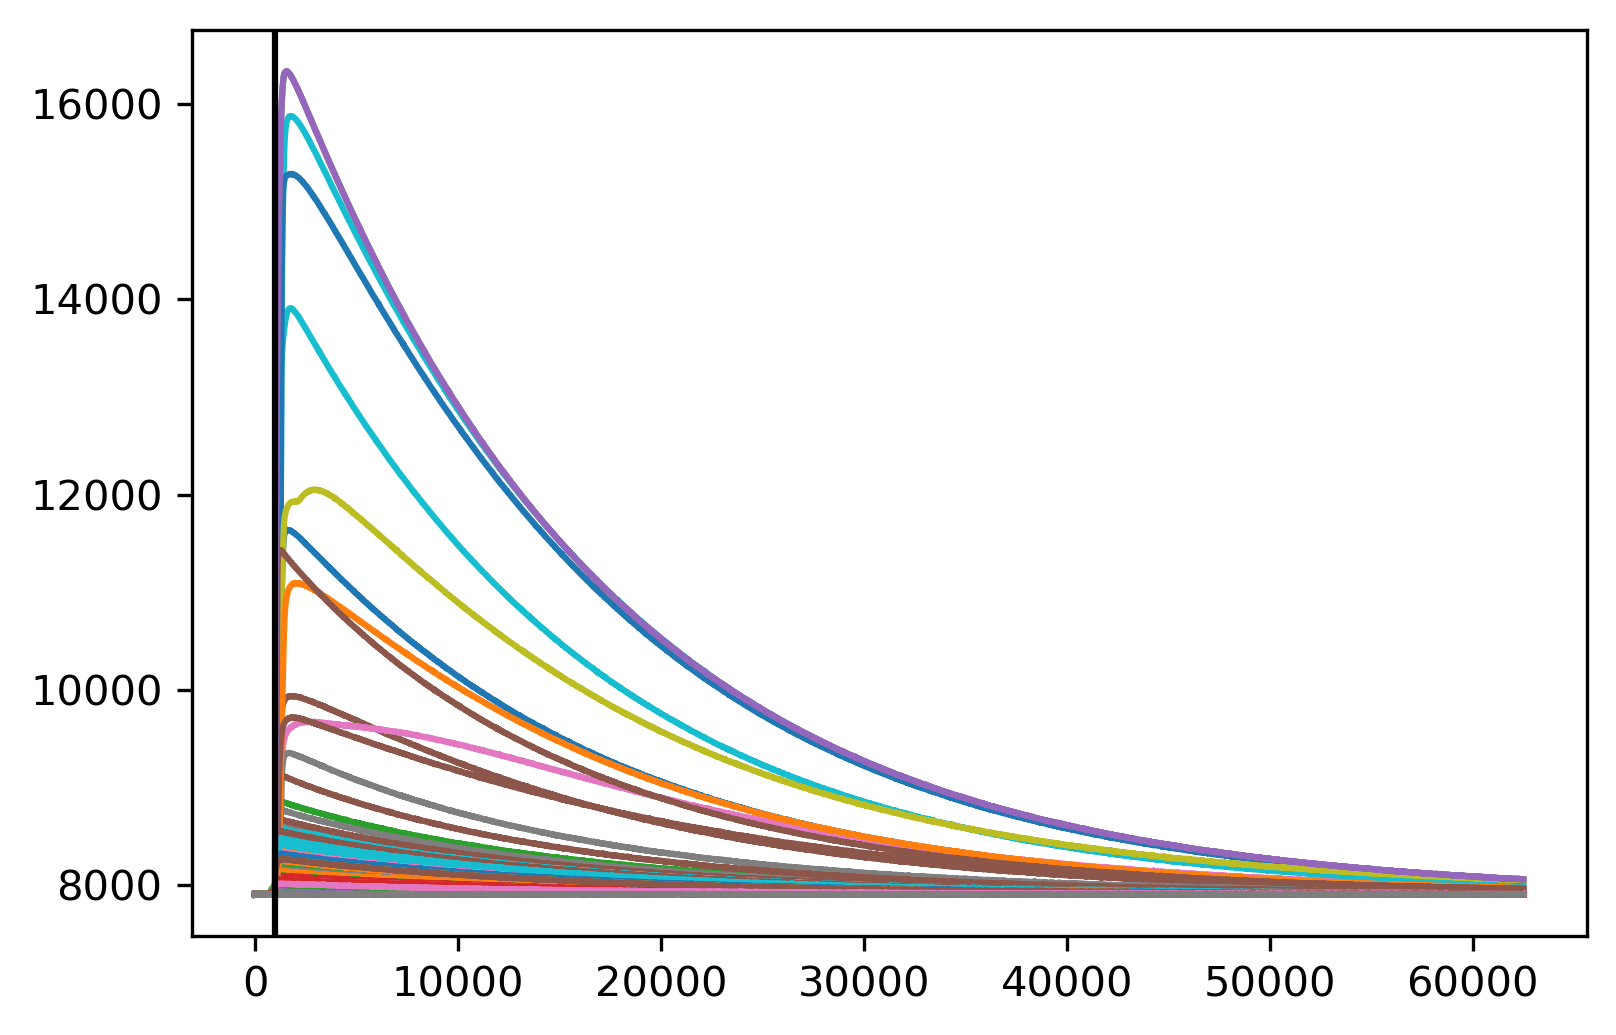

In [104]:
plt.figure(dpi=300)
for i in tqdm(range(len(test_np))):
    if i not in sat_i:
        plt.plot(savgol_filter(test_np[i], 21, 0))
#plt.xlim((700, 1200))
plt.axvline(1000, c='k')
#plt.ylim(7850, 8700)
plt.show()

In [20]:
sat_i

[1,
 125,
 383,
 715,
 1065,
 1174,
 1817,
 1860,
 2085,
 2216,
 2377,
 2444,
 2580,
 2621,
 2695,
 2887,
 3018,
 3180,
 3468,
 3494,
 3720,
 3967]

  0%|          | 0/200 [00:00<?, ?it/s]

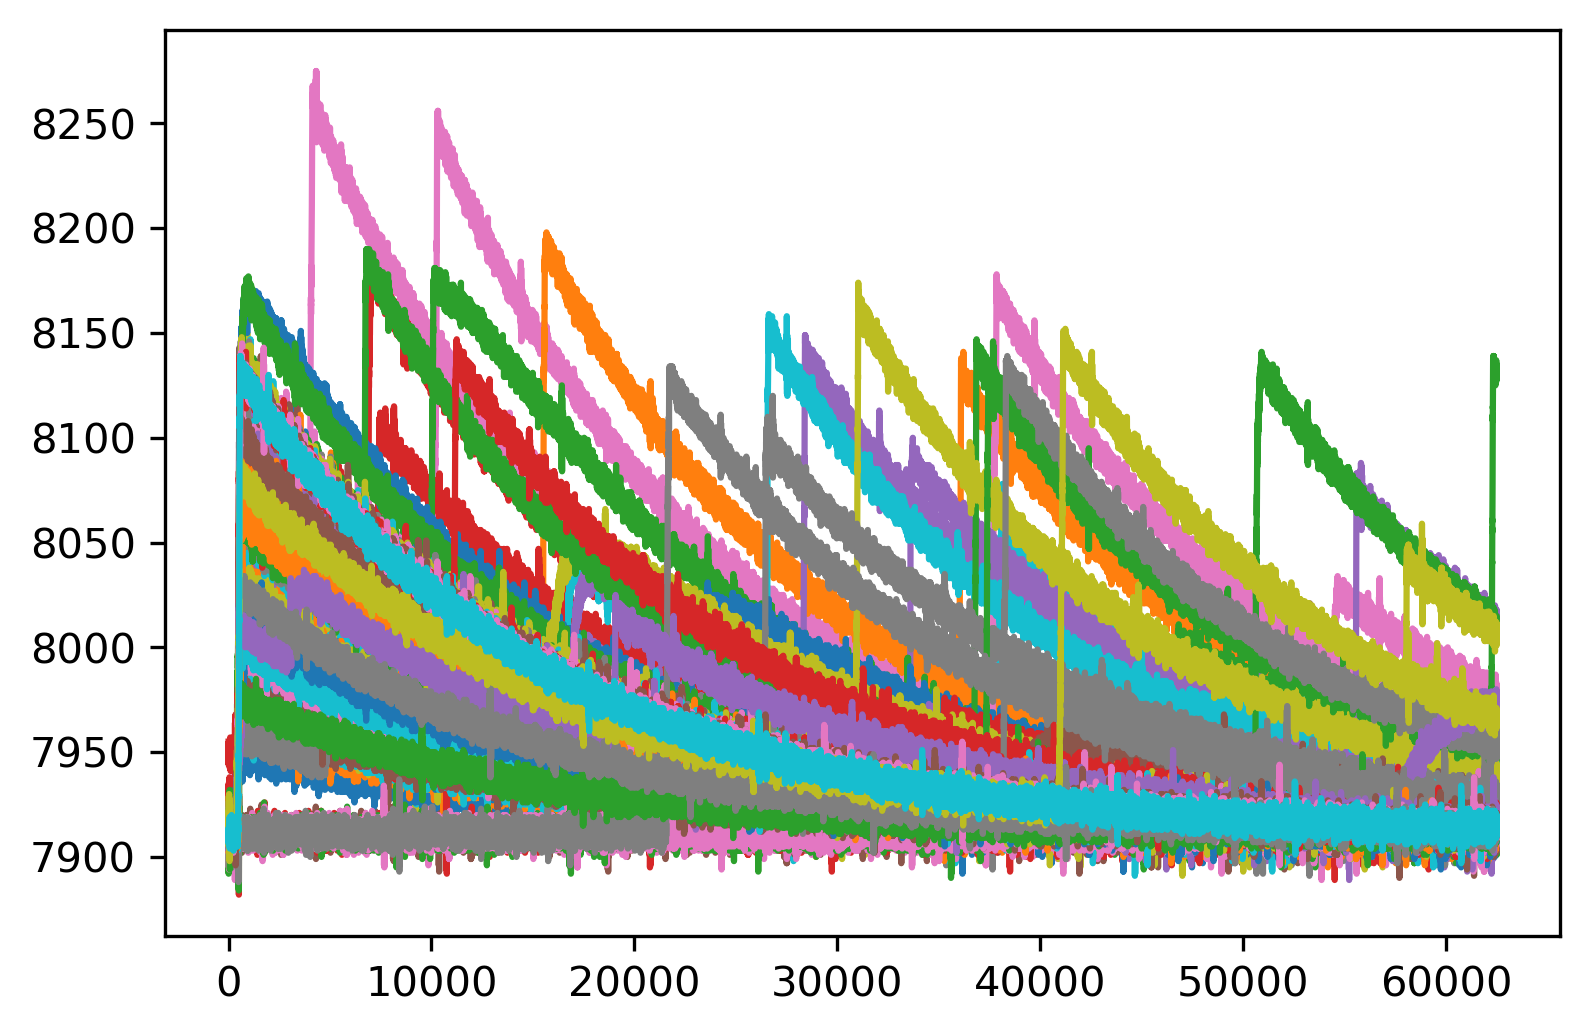

In [20]:
plt.figure(dpi=300)
for i in tqdm(range(200)):
    plt.plot(test_np[i])
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

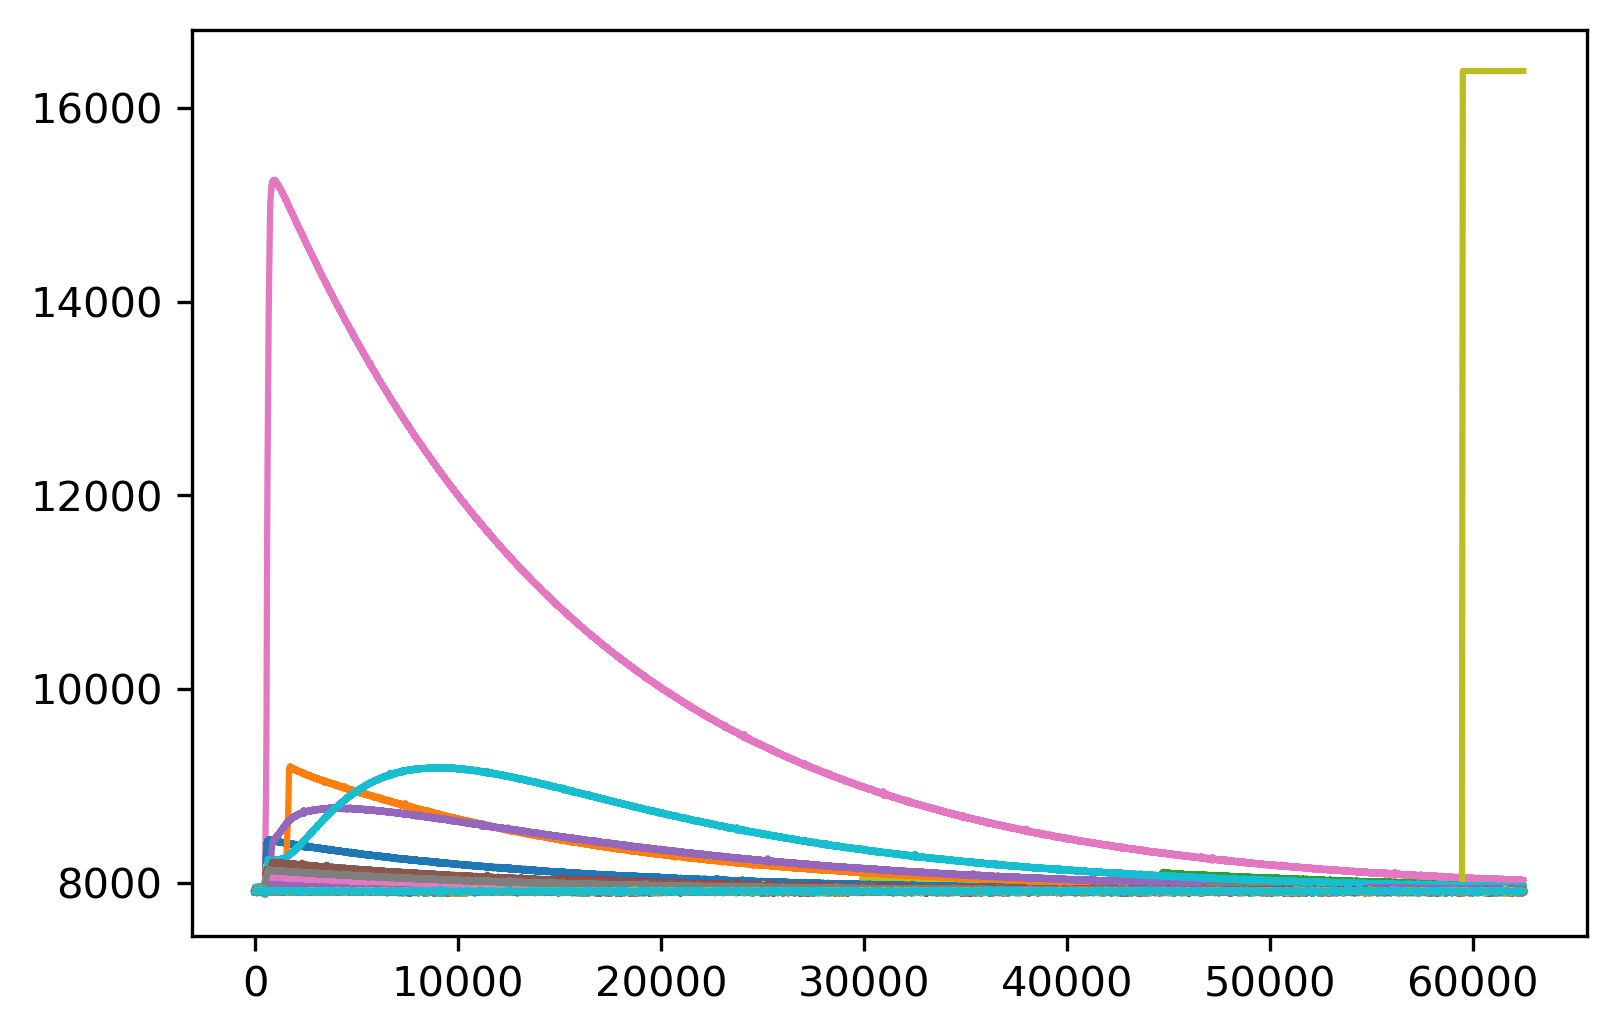

In [34]:
plt.figure(dpi=300)
for i in tqdm(range(3000,3500)):
    plt.plot(test_np[i])
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

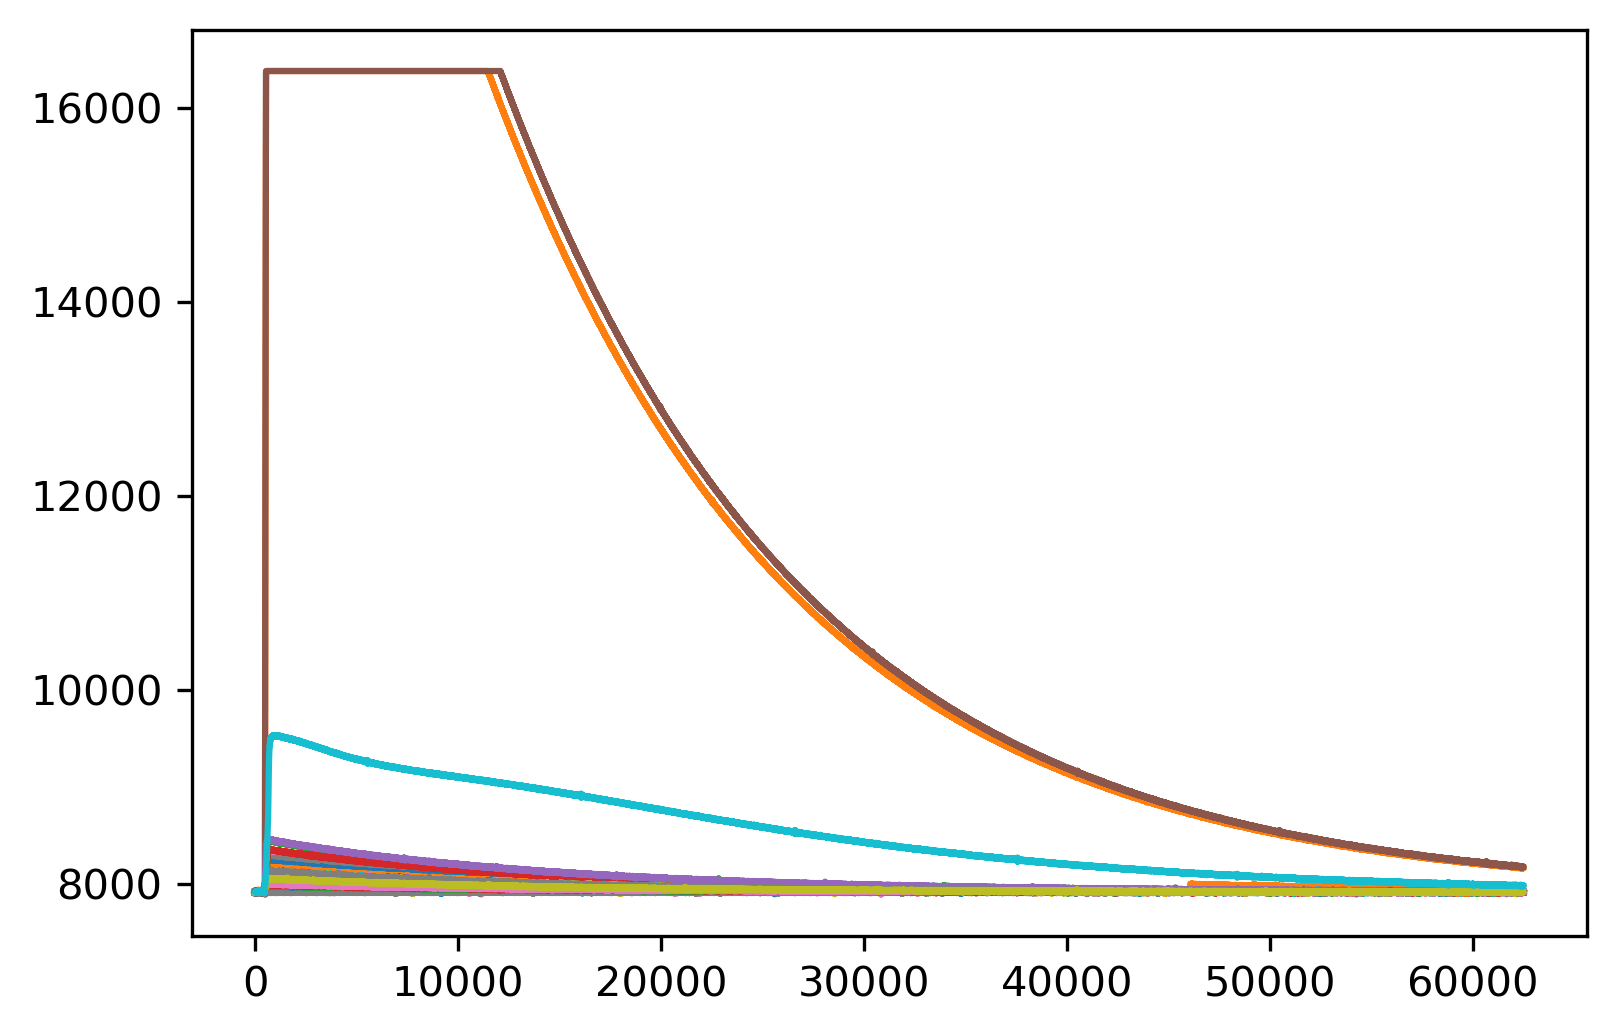

In [25]:
plt.figure(dpi=300)
for i in tqdm(range(200)):
    plt.plot(test_np[i])
plt.show()

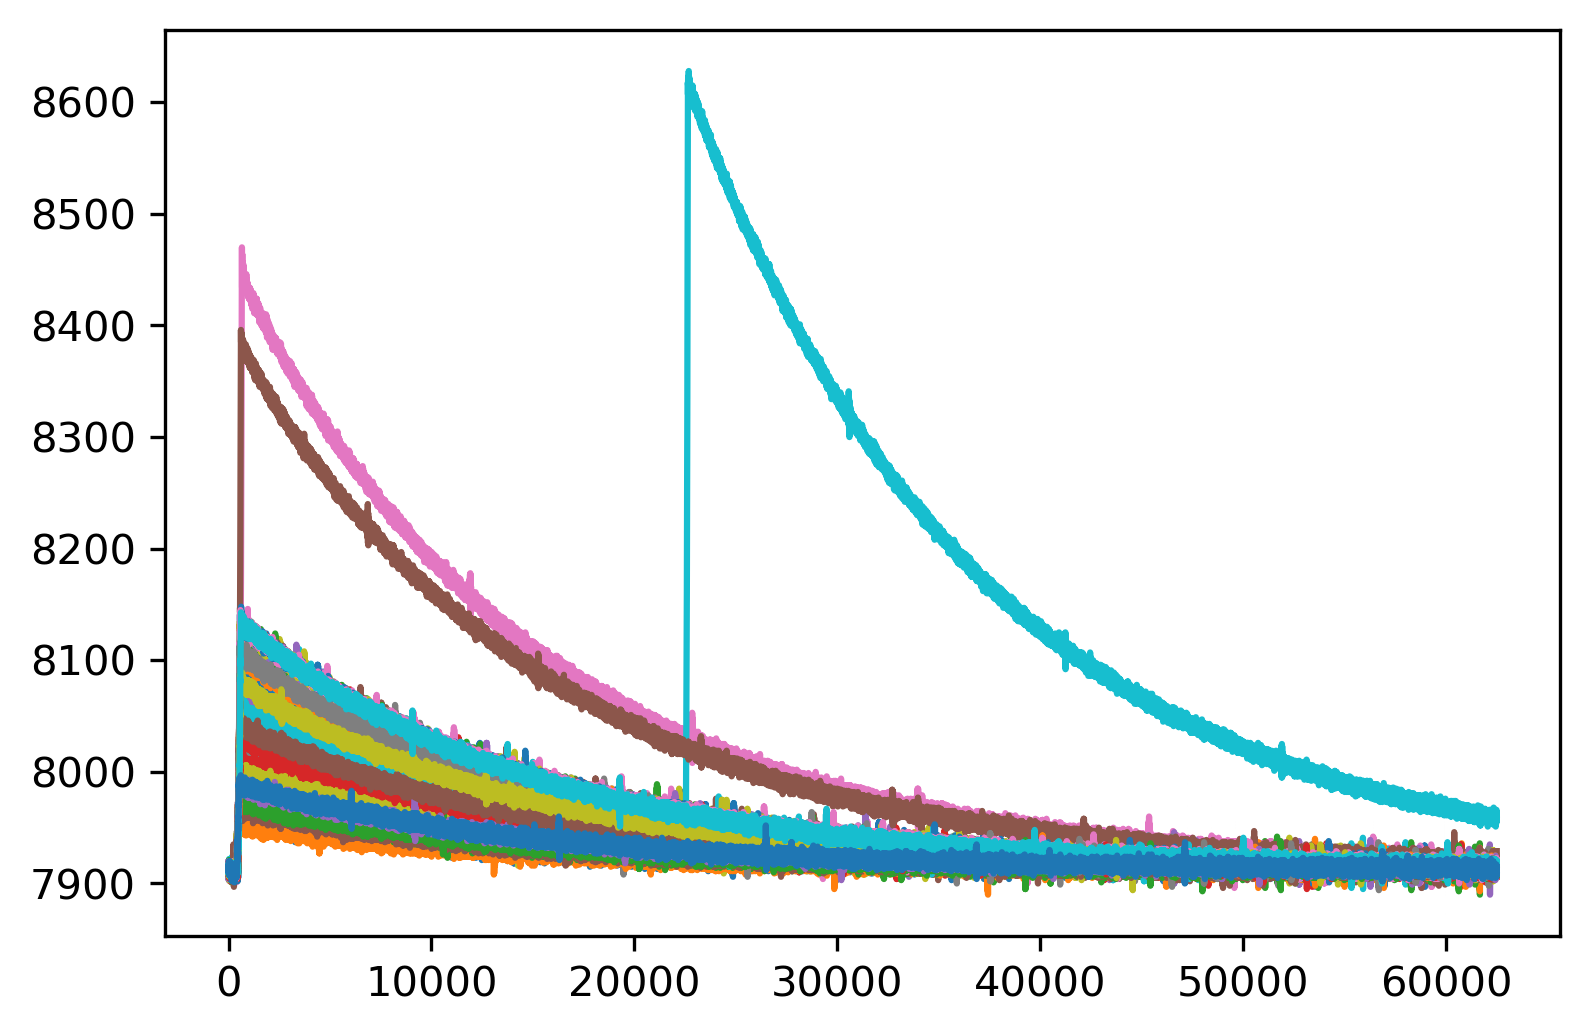

In [9]:
plt.figure(dpi=300)
for i in iss:
    plt.plot(test_np[i])
plt.show()

In [30]:
f['event_data'][400]

(400, 0, 1083093341, 7915, 7, 0, 63285, 0, 7910, 7910, 7910, 7910)

In [31]:
1083093341/250e6

4.332373364

In [33]:
f['raw_data']

<HDF5 dataset "raw_data": shape (5990, 62500), type "<u2">